In [1]:
# import packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# load data
m4_dat = pd.read_fwf('NGC6121-1.dat',  names=['source_id', 'ra', 'dec', 'phot_g_mean_mag'])
gia = pd.read_csv('m4_gaia_source.csv')

# prepare gia data for use
params = ['ra', 'dec']                                        # choose ra and dec columns from gia 
gia_params = np.array(gia[params])

NA = np.any(np.isnan(gia_params), axis = 1)                  # remove NA entries from selected gia data
gia_params = gia_params[~NA]

scalar = StandardScaler()                                     # ensure that all gia data entries are scalars
gia_params = scalar.fit_transform(gia_params)

In [2]:
# 410 PART
# create input training and testing data
size = gia_params.shape[0]                           
test_frac = 0.1

test_sel = np.random.choice([True, False], size = size, p = [test_frac, 1-test_frac])

input_train = gia_params[~test_sel]
input_test = gia_params[test_sel]

# create output training and testing data
m4 = gia['source_id'].isin(m4_dat.source_id)              # select only entries appearing in both data sets

output = np.column_stack([~m4, m4]).astype(int)[~NA]

output_train = output[~test_sel]
output_test = output[test_sel]

# create network layers
net = tf.keras.Sequential()

net.add(layers.Flatten(input_shape = gia_params.shape[1:]))
net.add(layers.Dense(10, activation = 'relu'))
net.add(layers.Dense(10, activation = 'relu'))
net.add(layers.Dense(output.shape[1], activation = 'softmax'))

net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# train and test the network
model_info = net.fit(input_train, output_train, batch_size = 32, epochs = 10, verbose = 0, validation_data = (input_test, output_test))

2022-05-19 20:59:20.538458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-19 20:59:20.538637: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-19 20:59:20.538699: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (291c97ae9296): /proc/driver/nvidia/version does not exist
2022-05-19 20:59:20.539145: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 20:59:20.668221: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of t

In [3]:
# training and validation accuracies
info = model_info.history

print("Training accuracy:", info['accuracy'])
print("Validation accuracy:", info['val_accuracy'])

Training accuracy: [0.9599510431289673, 0.9612147212028503, 0.9612371921539307, 0.961196780204773, 0.9613044857978821, 0.9612506628036499, 0.9613224864006042, 0.9614010453224182, 0.9613112211227417, 0.9613853096961975]
Validation accuracy: [0.9612258672714233, 0.9598309993743896, 0.9612258672714233, 0.9592043161392212, 0.9612258672714233, 0.9612258672714233, 0.9612258672714233, 0.9598714113235474, 0.9612258672714233, 0.9612258672714233]


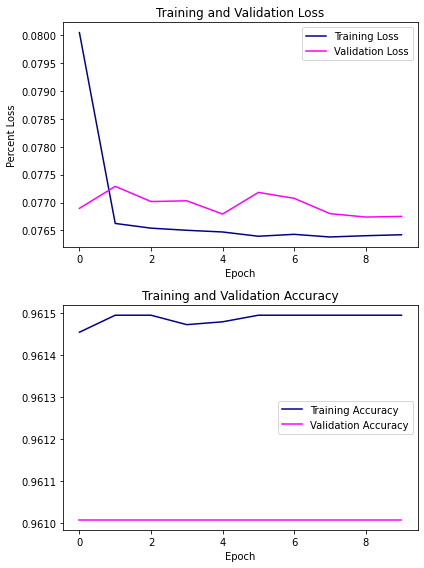

In [4]:
# visualize the training 
fig, ax = plt.subplots(2, 1, figsize = (6, 8))

# look at the learning loss compared to the validation loss
ax[0].plot(info['loss'], color = 'darkblue', label = 'Training Loss')
ax[0].plot(info['val_loss'], color = 'magenta', label = 'Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Percent Loss')
ax[0].legend();

# look at the learning accuracy compared to the validation accuracy
ax[1].plot(info['accuracy'], color = 'darkblue', label = 'Training Accuracy')
ax[1].plot(info['val_accuracy'], color = 'magenta', label = 'Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel;('Percent Accuracy')
ax[1].legend();

plt.tight_layout()

1. In every run of the model my training accuracies are almost constant, and in this run it starts at 0.9599 and only increases to 0.9614. Also in every run of the model the validation accuracies are almost constant or constant. In this run the validation accuracy stays constant at 0.9612. Because the training accuracy of this model does not significantly increase with successive training epochs this model does not learn well.

In [4]:
# predict m4 stars using the test set
class_pred = net.predict(input_test)

m4_pred = np.argmax(class_pred, axis = 1)

# get the testing accuracy
test_ac = net.evaluate(input_test, output_test, batch_size = 32)

1546/1546 [==============================] - 2s 2ms/step - loss: 0.0771 - accuracy: 0.9612


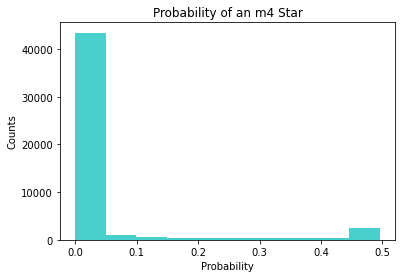

In [5]:
# confirm that I have potential m4 stars
plt.hist(class_pred[:,1], color = 'mediumturquoise')
plt.title('Probability of an m4 Star')
plt.xlabel('Probability')
plt.ylabel('Counts');

In [6]:
len(class_pred)

49466

2) This model has very little confidence in the points that it classifies as m4 stars because, of the 49466 stars that the model says are m4 stars, > 40000 of those stars have < 10% chance of actaully being an m4 star, and < 5000 stars are classified as an m4 star with > 40% probability. The fact that the model does not confidenty predict that any stars are m4 stars is not surprising because the plot titled "Training and Validation Accuracy" shows that the model is not robustly learning.

In [78]:
# look at some of the test set predictions
h = np.random.randint(len(input_test))

for i, p in enumerate(class_pred[h]):
    print(i, round(p*100, 2), '%')
    
best_guess = np.argmax(class_pred[h])
print('Best guess:', best_guess)

print("Truth class:", output_test[h])

0 99.95 %
1 0.05 %
Best guess: 0
Truth class: [1 0]


In [45]:
# make a horizontal shift to the inputs to check the model's predictive capabilities
k = np.random.randint(len(input_test))

x = input_test[k]
x = np.roll(x, 10, axis=0)

pred = net.predict(x[np.newaxis, ...])

for i, p in enumerate(pred[0]):
    print(i, round(p*100, 2), '%')
    
best_guess = np.argmax(pred)
print('best guess:', best_guess)
print("Truth class:", output_test[k]);

0 67.9 %
1 32.1 %
best guess: 0
Truth class: [0 1]


3. This model is supposed to be learning how to identify an m4 star using its right ascention and declenation. As previously mentioned, the plot "Training and Validation Accuracy" shows that the model does not gain accuracy as it trains, and therefore it is not learning much. To see if the model is learning something about sky positions of m4 stars I visualized some of the test set predictions; then I made a horizontal shift to the test data and made new predictions on the shifted data set. Making a shift of 1 does not effect the predictions, but a shift of 10 changes the model's confidence about its class predictions which sometimes leads to misclassification. Since the test predictions are affected by spatial transformations I can conlcude that the model is learning something about right ascention and declenation of m4 stars like I want it to.

4) I do not think that a more sophsticated DNN model (i.e. more layers or more nodes per layer) could do a better job of classifying the data than this model does. The training data only contains information about right ascention and declenation, and only so much can be extracted from this information. This model learns all it can from these two parameters, and a more complex model only increases the likelihood that the model will overfit the data and lose predictive capabilities.

In [1]:
# 510 PART
# import packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# load data
m4_dat = pd.read_fwf('NGC6121-1.dat',  names=['source_id', 'ra', 'dec', 'phot_g_mean_mag'])
gia = pd.read_csv('m4_gaia_source.csv')

# prepare gia data for use
new_params = ['ra', 'dec', 'parallax', 'pm', 'pmra', 'pmdec']                                        # choose ra and dec columns from gia 
new_gia_params = np.array(gia[new_params])

NA2 = np.any(np.isnan(new_gia_params), axis = 1)                  # remove NA entries from selected gia data
new_gia_params = new_gia_params[~NA2]

scalar = StandardScaler()                                     # ensure that all gia data entries are scalars
new_gia_params = scalar.fit_transform(new_gia_params)

# create input training and testing data
size2 = new_gia_params.shape[0]                           
test_frac = 0.1

test_sel2 = np.random.choice([True, False], size = size2, p = [test_frac, 1-test_frac])

input_train2 = new_gia_params[~test_sel2]
input_test2 = new_gia_params[test_sel2]

# create output training and testing data
m4 = gia['source_id'].isin(m4_dat.source_id)              # select only entries appearing in both data sets

output2 = np.column_stack([~m4, m4]).astype(int)[~NA2]

output_train2 = output2[~test_sel2]
output_test2 = output2[test_sel2]

# create network layers
net2 = tf.keras.Sequential()

net2.add(layers.Flatten(input_shape = new_gia_params.shape[1:]))
net2.add(layers.Dense(10, activation = 'relu'))
net2.add(layers.Dense(10, activation = 'relu'))
net2.add(layers.Dense(output2.shape[1], activation = 'softmax'))

net2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'FalsePositives'])

# train and test the network
model_info2 = net2.fit(input_train2, output_train2, batch_size = 32, epochs = 10, verbose = 0, validation_data = (input_test2, output_test2))

2022-05-19 22:28:58.878981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-19 22:28:58.879063: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-19 22:28:58.879101: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (291c97ae9296): /proc/driver/nvidia/version does not exist
2022-05-19 22:28:58.879488: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 22:28:59.008309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of t

In [2]:
# training and validation accuracies
info2 = model_info2.history

print("Training accuracy:", info2['accuracy'])
print("Validation accuracy:", info2['val_accuracy'])

Training accuracy: [0.9830942749977112, 0.9873297810554504, 0.9875280261039734, 0.9876062273979187, 0.9876871705055237, 0.987567126750946, 0.9877625703811646, 0.9876592755317688, 0.9877123236656189, 0.987765371799469]
Validation accuracy: [0.9881662726402283, 0.9882921576499939, 0.9879900217056274, 0.9878641366958618, 0.9877886176109314, 0.9892740845680237, 0.9886950254440308, 0.9886950254440308, 0.9883173704147339, 0.9884432554244995]


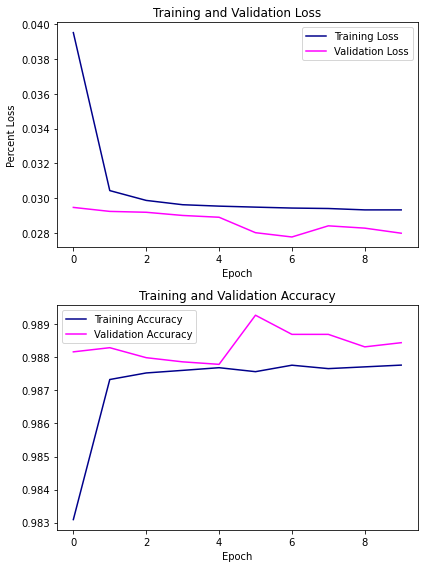

In [3]:
# visualize the training 
fig, ax = plt.subplots(2, 1, figsize = (6, 8))

# look at the learning loss compared to the validation loss
ax[0].plot(info2['loss'], color = 'darkblue', label = 'Training Loss')
ax[0].plot(info2['val_loss'], color = 'magenta', label = 'Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Percent Loss')
ax[0].legend();

# look at the learning accuracy compared to the validation accuracy
ax[1].plot(info2['accuracy'], color = 'darkblue', label = 'Training Accuracy')
ax[1].plot(info2['val_accuracy'], color = 'magenta', label = 'Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel;('Percent Accuracy')
ax[1].legend();

plt.tight_layout()

I chose to include parallax, pm, pmra, and pmdec in my training set because pm measures the observed changes in location of a celestial body, pmra measures the proper motion in right ascention, and pmdec measures proper motion in declenation. I chose to include all three pm measurements because pmra and pmdec measure proper motion in the directions that I am using to define the spatial locations of each m4 star so including these measurements should produce more confident model predictions because they allow me to give the model specific location information and how that location can vary. Using these new data parameters my new network achieves a training accuracy of between 0.9831 and 0.9878 and a validation accuracy of between 0.9882 and 0.9884. This model acheives a higher training and validation accuracy than the more simplistic model does, and the training accuracy drastically increases from its starting position which means that the model is actually learning something.

In [4]:
# predict m4 stars using the test set
class_pred2 = net2.predict(input_test2)

m4_pred2 = np.argmax(class_pred2, axis = 1)

# get the testing accuracy
test_ac2 = net2.evaluate(input_test2, output_test2, batch_size = 32)

1242/1242 [==============================] - 3s 2ms/step - loss: 0.0280 - accuracy: 0.9884 - false_positives: 459.0000


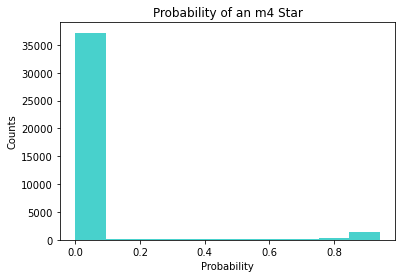

In [5]:
# confirm that I have potential m4 stars
plt.hist(class_pred2[:,1], color = 'mediumturquoise')
plt.title('Probability of an m4 Star')
plt.xlabel('Probability')
plt.ylabel('Counts');

In [24]:
# save all misclassified test inputs to arrays
pr = []
c = []

for j in range(len(input_test2)):                     #once for every entry in input_test2
    best_guess = np.argmax(class_pred2[j])            # make a max prediction for that entry 

    if best_guess != output_test2[j][1]:              # if that max prediction doesn't equal the test output              
        for i, p in enumerate(class_pred2[j]):        # for each class and probability in the test input
            pr.append(np.round(p*100, 2))             # append the probability to an array
            c.append(i)                               # append the class to an array 

# create a data frame for each misclassified input
d = {'class': c, 'prob': pr}
cp = pd.DataFrame(d)
#print(cp)

# find the number of misclassified inputs with a probability greater than 80%
conf_misclass = np.count_nonzero(cp['prob'] > 80.00)                              #count each prob value > 80%
print('The model misclassifies', conf_misclass, 'test inputs with a probability > 80%')

The model misclassifies 193 test inputs with a probability > 80%


In [26]:
len(class_pred2), len(cp)

(39717, 918)

The more informed model predicts that over 35000 stars belong to m4 with <= 10% probabilty so this model is not very confident that it is identifying most stars correctly. Despite this, the model is able to classify < 5000 stars as belonging to m4 with a probability > 80%, so this model is performing better than the more simplistic model because it has greater predictive confidence. Of the < 5000 stars that are misclasified, 193 of them are misclassified with a confidence > 80%. This is a small number of confident false-positives, but it signals that the model is starting to overfit the data that it is given, and therefore it is having difficulty generalizing to new data.

*Note: The length of my misclassified dataframe, cp, is longer than the number of any of the validation false postives for any single epoch listed in info2, and it is shorter than the combined total of the false positives from each epoch. The false_postive metric is counting the false postive weights in each epoch, so I expect cp to be of a similar length to the number of validation false positives per epoch. I have gone through my for loop and commented what I understand each line to do, and at the moment I am not sure why there is a discrepancy.